hugging face 트랜스포머는 아키텍쳐와 작업마다 전용 클래스를 제공함  
일반적으로 <"ModelName">For<"Task"> 형식을 따름  
AutoModel 클래스를 사용하는 경우 AutoModelFor<"Task"> 형식임  
지금 사용하려는건 NER이니까 NER이 들어갈까?


하지만 내가 원하는 task가 없다면 어떻게 될까? 멘붕와서 어떻게 직접 만들지 고민하게됨  
이를 위해 hugging face는 헬퍼 함수를 통해 커스텀할 수 있음 

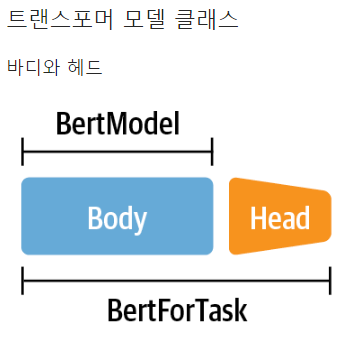

트랜스포머의 가장 큰 장점이라고 생각하는 모델의 구조  
Body는 이미 대용량 데이터로 사전 학습이 된 모델을 사용하고 마지막 Head를 내가 원하는 task로 학습을 시켜버림  
따라서 내가 원하는 특정 task에 맞는 모델로 변경가능  

In [2]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig #표준 XLM-R 설정을 가져옴

    def __init__(self, config):
        super().__init__(config) #RobertaPreTrainedModel 클래스 초기화
        self.num_labels = config.num_labels #분류할 레이블 갯수 설정
        self.roberta = RobertaModel(config, add_pooling_layer=False) #Robert a 모델 가져와서 로드해줌 add_pooling_layer은 기본 true 
        #만약 True라면 첫 번째 토큰의 은닉 상태만 밀집 층과 활성화 함수에 통과
        #FALSE이므로 모든 토큰의 은닉 상태를 출력
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        
        self.init_weights()# 모델의 바디는 학습된 가중치 로드 헤드를 랜덤하게 초기

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                labels=None, **kwargs):
        # 모델 바디를 사용해 인코더 표현을 얻습니다.
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # 인코더 표현을 헤드에 통과시킵니다.
        sequence_output = self.dropout(outputs[0]) #여기서 왜 [0]을 넣어주지 일반적으로 그냥 출력을 넣던데
        # [batch,seq,hiden]같이 3차원이 아닌가? 맨 앞 차원에 1이 추가 된듯? 나중에 출력 차원을 프린트해봐야 함
        logits = self.classifier(sequence_output)
        # 손실을 계산합니다.
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # 모델 출력 객체를 반환합니다.
        return TokenClassifierOutput(loss=loss, logits=logits,
                                     hidden_states=outputs.hidden_states,
                                     attentions=outputs.attentions)

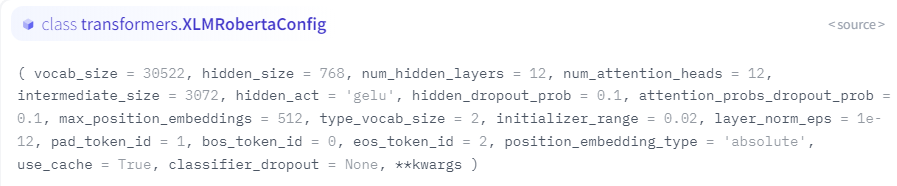

In [9]:
from collections import defaultdict
from datasets import DatasetDict
from datasets import load_dataset
langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
# 키가 없는 경우 DatasetDict를 반환합니다.
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # 다국어 말뭉치를 로드합니다.
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # 각 분할을 언어 비율에 따라 다운샘플링하고 섞습니다.
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows))))
tags = panx_ch["de"]["train"].features["ner_tags"].feature

In [17]:
tags

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

In [13]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
print(index2tag)
print(tag2index)

{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6}


In [15]:
from transformers import AutoConfig
xlmr_model_name = "xlm-roberta-base"
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)
'''
AutoConfig는 모델 구조의 청사진을 가짐 model_name을 가진 것이 있으면 모델에 연관된 설정 파일이 자동으로 다운
'''

In [18]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))
'''

'''

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

E:\anaconda\envs\prac\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Owner\.cache\huggingface\hub\models--xlm-roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm

In [23]:
import pandas as pd
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)
text = "Jack Sparrow loves New York!"
xlmr_tokens = xlmr_tokenizer(text).tokens()
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [29]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)#각 토큰에 대해 이게 뭔지 NER 하는 출력이 나옴
print(f"시퀀스에 있는 토큰 개수: {len(xlmr_tokens)}")
print(f"출력 크기: {outputs.shape}") #[batch,tokens,labels]

시퀀스에 있는 토큰 개수: 10
출력 크기: torch.Size([1, 10, 7])


In [30]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

'''
아직 분류 헤드가 학습이 안된 상태라서 당연히 답이 틀린게 맞음
'''

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC


In [31]:
def tag_text(text, tags, model, tokenizer):
    # 토큰을 준비합니다.
    tokens = tokenizer(text).tokens()
    # 시퀀스를 ID로 인코딩합니다.
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device) #위에서 사용한 xlmr_tokenizer.encode 랑 무슨 차이가 있는거임?
    # 가능한 일곱 개의 클래스에 대한 분포를 예측합니다.
    outputs = model(input_ids)[0]
    # 토큰마다 가장 가능성 있는 클래스를 argmax로 구합니다.
    predictions = torch.argmax(outputs, dim=2)
    # 데이터프레임으로 변환합니다.
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

In [37]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)
de_example = panx_de["train"][0]
words, labels = de_example["tokens"], de_example["ner_tags"]
print(words)
print(labels)

['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]


In [38]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)#is_split_into_words 인자는 이미 단어로 나눠져 있어서 True
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [39]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])
# 단어 아이디는 토크나이저로 두 개의 부분 단어로 나눠진 '_Einwohner'와 'n'이 하나의 단어이며, 첫 번째 부분단어 이후 마스킹 단어임을 구분할 수 있는 기준임
# 내가 이해한게 맞다면 뒤에 n은 IGN 으로 마스킹 된다는 것

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [40]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx: # Word IDs가 이전과 같다면 -100으로 값을 넣어버림
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx]) #Word IDs가 이전과 다르다면 LABEL ids을 넣어줌
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids] #label ids에 맞게 tag로 바꿔줌 
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

'''
왜 하필 -100으로 인덱스 하냐?
일반적으로 torch nn Cross entropyloss의 경우 ignore index 속성 기본값이 -100이기 때문에
훈련 하는동안 -100 인덱스는 전부 무시해버림
'''

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [41]:
def tokenize_and_align_labels(examples): #위에서 했던거 전부 하나의 함수에 담아버림
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, #truncation는 일정 길이보다 긴 문장을 짤라버림 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [42]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True,
                      remove_columns=['langs', 'ner_tags', 'tokens'])

In [43]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [49]:
panx_ch["de"]['train']

Dataset({
    features: ['tokens', 'ner_tags', 'langs'],
    num_rows: 12580
})

In [44]:
panx_de_encoded['train'] #여기서 attention_mask가 갑자기 어디서 나타난거임?

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 12580
})

In [52]:
print(panx_de_encoded['train']['attention_mask'][:3])
'''
xlmr_tokenizer에서 나온거였음 truncation이 true로 되어있으니깐 그냥 잘려서 나오는데 만약 padding이 true였으면 늘린 부분은 0으로 만들어져있을거임
내가 생각한 그 Causal 마스크가 아니였음
'''

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


'\nxlmr_tokenizer에서 나온거였음 truncation이 true로 되어있으니깐 그냥 잘려서 나오는데 만약 padding이 true였으면 늘린 부분은 0으로 만들어져있을거임\n내가 생각한 그 Causal 마스크가 아니였음\n'

일반적으로 NER 성능 평가는 텍스트 분류 모델 평가와 비슷함   
정밀도, 재현율,f1 score를 사용함  
유일한 차이는 예측 하나를 정확하다고 판단하려면 한 문장의 전체 단어가 맞아야 올바르다고 판단함

In [54]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [55]:
import numpy as np

def align_predictions(predictions, label_ids): #위에서 사용한 성능 지표를 사용하기 위해 출력을 원하는 타입으로 바꾸는 함수
    preds = np.argmax(predictions, axis=2) #[batch,seq_len,label] 출력 모양인데 argmax 해서 [batch,seq_len]으로 바뀜
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # 레이블 IDs = -100 무시
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]]) #위에 y_true 같이 tag로 바꿔서 append 해줌
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

In [56]:
from transformers import TrainingArguments

num_epochs = 3
# 코랩에서 GPU 메모리 부족 에러가 나는 경우 batch_size를 16으로 줄여 주세요.
batch_size = 24  # 16
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch",
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False,
    logging_steps=logging_steps, push_to_hub=True)

In [57]:
from huggingface_hub import notebook_login

notebook_login()

In [58]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [59]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)
#인자로 토크나이저를 받고 배치에서 가장 큰 시퀀스를 기준으로 입력을 패딩시킴 앞에서 본대로 -100으로 레이블을 만들어줌 

In [60]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [61]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [62]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

E:\anaconda\envs\prac\lib\site-packages\huggingface_hub\utils\_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/kwkwkwkwpark/xlm-roberta-base-finetuned-panx-de into local empty directory.


In [63]:
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

E:\anaconda\envs\prac\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.256800,0.172448,0.816267
2,0.129200,0.136865,0.848336
3,0.081900,0.131676,0.864729


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.93k [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 1.00/16.3M [00:00<?, ?B/s]

Upload file runs/Jun24_17-28-41_DESKTOP-GRA030L/1719217956.715774/events.out.tfevents.1719217956.DESKTOP-GRA03…

Upload file sentencepiece.bpe.model:   0%|          | 1.00/4.83M [00:00<?, ?B/s]

Upload file runs/Jun24_17-28-41_DESKTOP-GRA030L/events.out.tfevents.1719217956.DESKTOP-GRA030L.16680.0:   0%| …

To https://huggingface.co/kwkwkwkwpark/xlm-roberta-base-finetuned-panx-de
   ae47a3a..9f7277c  main -> main

To https://huggingface.co/kwkwkwkwpark/xlm-roberta-base-finetuned-panx-de
   9f7277c..fe30690  main -> main



'https://huggingface.co/kwkwkwkwpark/xlm-roberta-base-finetuned-panx-de/commit/9f7277cc70514a2e79af2350c03a35205e2922fd'

In [64]:
df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1']]
df = df.rename(columns={"epoch":"Epoch","loss": "Training Loss", "eval_loss": "Validation Loss", "eval_f1":"F1"})
df['Epoch'] = df["Epoch"].apply(lambda x: round(x))
df['Training Loss'] = df["Training Loss"].ffill() #ffill은 nan 값을 근처 값이랑 똑같이 따라함
df[['Validation Loss', 'F1']] = df[['Validation Loss', 'F1']].bfill().ffill() # bfill 결측값이 바로 아래값과 동일하게 설정됩니다.
df.drop_duplicates()

,Epoch,Training Loss,Validation Loss,F1
0,1,0.2568,0.172448,0.816267
2,2,0.1292,0.136865,0.848336
4,3,0.0819,0.131676,0.864729


In [65]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O
